In [581]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from lifetimes import BetaGeoFitter 
from lifetimes.plotting import plot_probability_alive_matrix
import joblib
from lifetimes.plotting import plot_frequency_recency_matrix,plot_dropout_rate_heterogeneity
from lifetimes.utils import calibration_and_holdout_data
from lifetimes.plotting import plot_calibration_purchases_vs_holdout_purchases
from lifetimes.plotting import plot_history_alive,plot_transaction_rate_heterogeneity
from lifetimes.plotting import plot_period_transactions,plot_expected_repeat_purchases,plot_cumulative_transactions
import dill
from lifetimes.utils import summary_data_from_transaction_data
%matplotlib inline

In [582]:
pickle_file_path = './BGFprpur.pkl'

### Reading Data from File 

In [583]:
df=pd.read_csv("Gafinal.csv",low_memory=False,parse_dates=['date'])

In [584]:
df=df.loc[df['totals.transactionRevenue']>0]
#df['totals.transactionRevenue']=np.log(df['totals.transactionRevenue'])

### Creating Summary Data

In [473]:
summary=summary_data_from_transaction_data(
    transactions=df,
    customer_id_col='fullVisitorId',
    datetime_col='date',
    monetary_value_col='totals.transactionRevenue',
    datetime_format=None,
    observation_period_end=None,
    freq='D',
    freq_multiplier=1)

In [474]:
df_grp=df.groupby('fullVisitorId')['totals.transactionRevenue'].mean()

In [475]:
df_grp=df_grp.reset_index().set_index('fullVisitorId')

In [476]:
summary=summary.merge(df_grp,how='inner',left_index=True,right_index=True)

In [477]:
summary.drop('monetary_value',axis=1,inplace=True)

In [478]:
summary=summary.rename(columns = {"totals.transactionRevenue": "monetary_value"})

### BetaGeoFitter 

In [479]:
bgf = BetaGeoFitter(penalizer_coef=0.00001)
bgf.fit(frequency=summary['frequency'],recency=summary['recency'],T=summary['T'])

<lifetimes.BetaGeoFitter: fitted with 16141 subjects, a: 2.63, alpha: 3.67, b: 1.07, r: 0.02>

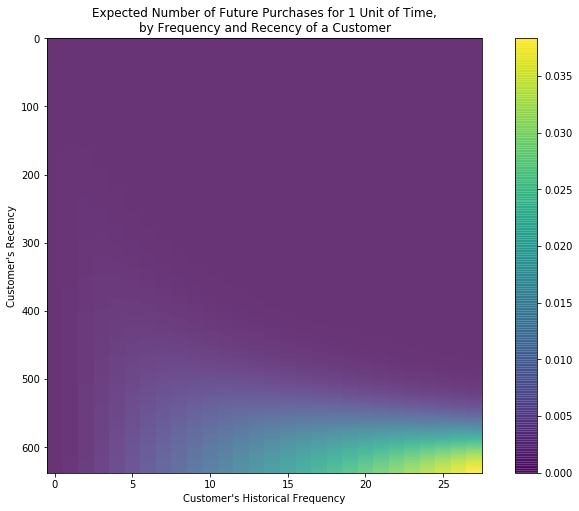

In [480]:
fig = plt.figure(figsize=(12,8))
ax=plot_frequency_recency_matrix(bgf,alpha=0.8)


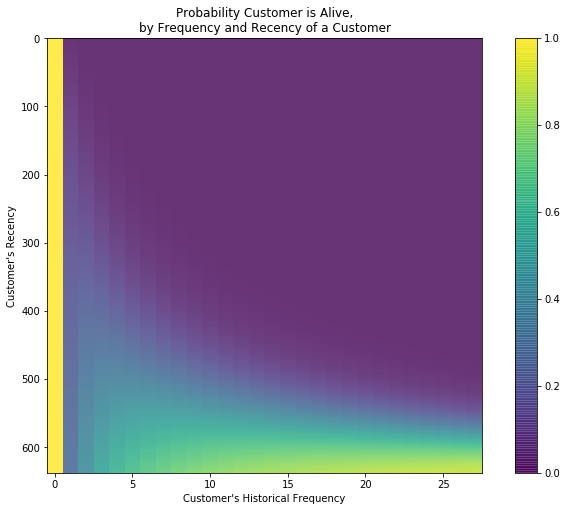

In [481]:
fig = plt.figure(figsize=(12,8))
plot_probability_alive_matrix(bgf,alpha=0.8)


<Figure size 864x576 with 0 Axes>

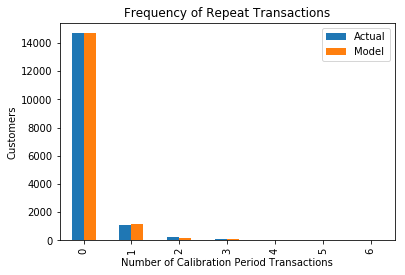

In [482]:
fig = plt.figure(figsize=(12,8))
plot_period_transactions(bgf)

### Predict Purchase for 180 Days

In [483]:
bgf.summary

,coef,se(coef),lower 95% bound,upper 95% bound
r,0.022537,0.000739,0.021088,0.023987
alpha,3.665586,0.307331,3.063217,4.267954
a,2.627424,0.323648,1.993074,3.261774
b,1.068951,0.159130,0.757056,1.380846


In [484]:
t = 180
summary['predicted_purchases'] = bgf.conditional_expected_number_of_purchases_up_to_time(t, summary['frequency'], summary['recency'], summary['T'])
summary.sort_values(by='predicted_purchases').tail(5)

,frequency,recency,T,monetary_value,predicted_purchases
fullVisitorId,,,,,
6152978475187911748,4.0,293.0,327.0,3.989800e+07,0.744304
9249130983722228273,4.0,287.0,291.0,1.012000e+08,0.954754
6010250598436085923,10.0,473.0,563.0,5.160800e+08,0.957493
2904329822175970539,7.0,143.0,167.0,5.311562e+08,1.711446
5833663755166786980,4.0,21.0,24.0,3.367286e+07,1.854797


### Predict Purchase for 365 Days

In [485]:
t = 365
summary['predicted_purchases'] = bgf.conditional_expected_number_of_purchases_up_to_time(t, summary['frequency'], summary['recency'], summary['T'])
summary.sort_values(by='predicted_purchases').tail(5)

,frequency,recency,T,monetary_value,predicted_purchases
fullVisitorId,,,,,
6152978475187911748,4.0,293.0,327.0,3.989800e+07,1.129969
9249130983722228273,4.0,287.0,291.0,1.012000e+08,1.419977
6010250598436085923,10.0,473.0,563.0,5.160800e+08,1.528334
5833663755166786980,4.0,21.0,24.0,3.367286e+07,1.961665
2904329822175970539,7.0,143.0,167.0,5.311562e+08,2.222259


In [486]:
summary.to_csv('./CappredGraph.csv',index=True)

### Test Train Split

In [487]:
summary_cal_holdout = calibration_and_holdout_data(df[df['totals.transactionRevenue']>0], 'fullVisitorId', 'date',
                                        calibration_period_end='2017-10-01',
                                        monetary_value_col= 'totals.transactionRevenue')

In [488]:
summary_cal_holdout.columns

Index(['frequency_cal', 'recency_cal', 'T_cal', 'monetary_value_cal',
       'frequency_holdout', 'monetary_value_holdout', 'duration_holdout'],
      dtype='object')

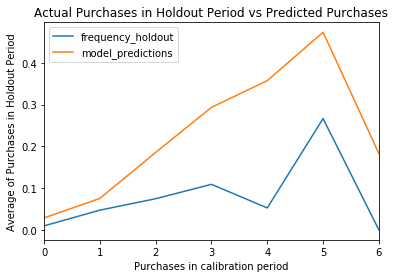

In [489]:
bgf.fit(summary_cal_holdout['frequency_cal'], summary_cal_holdout['recency_cal'], summary_cal_holdout['T_cal'])
plot_calibration_purchases_vs_holdout_purchases(bgf, summary_cal_holdout)

### Plots

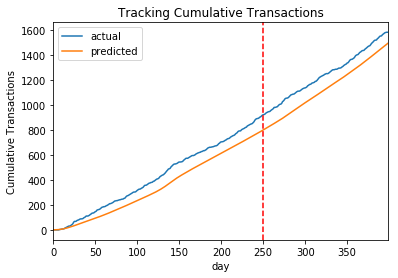

In [490]:
plot_cumulative_transactions(bgf,df[df['totals.transactionRevenue'] >0],'date','fullVisitorId',t=400,t_cal=250)

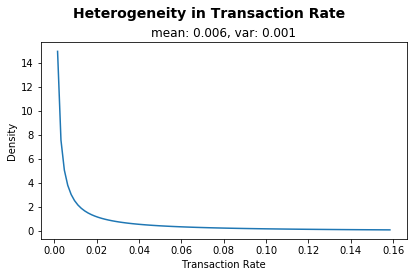

In [491]:
plot_transaction_rate_heterogeneity(bgf)

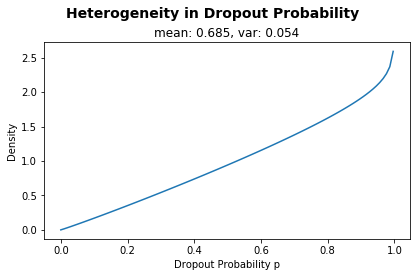

In [492]:
plot_dropout_rate_heterogeneity(bgf)

### Predict Purchase Per Individual

In [493]:
t = 180 #predict purchases in 10 periods
individual = summary.iloc[10]
print(individual)
# The below function is an alias to `bfg.conditional_expected_number_of_purchases_up_to_time`
bgf.predict(t, individual['frequency'], individual['recency'], individual['T'])

frequency              0.000000e+00
recency                0.000000e+00
T                      3.640000e+02
monetary_value         3.359000e+07
predicted_purchases    1.693544e-02
Name: 0007933257389091624, dtype: float64


0.011411096149923236

### Plot Individual Top Cust Alive/Purchase

(array([736511., 736603., 736695., 736785., 736876., 736968., 737060.,
        737150.]), <a list of 8 Text xticklabel objects>)

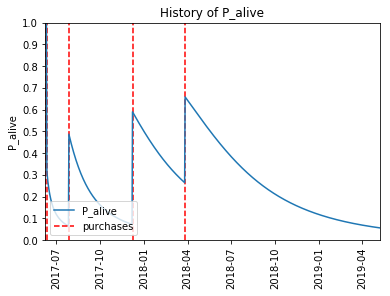

In [494]:
id = '6152978475187911748'
days_since_birth = 700
sp_trans = df.loc[df['fullVisitorId'] == id]
ax=plot_history_alive(bgf, days_since_birth, sp_trans, 'date')
plt.xticks(rotation=90)

(array([736573., 736634., 736695., 736754., 736815., 736876., 736938.,
        736999., 737060., 737119.]), <a list of 10 Text xticklabel objects>)

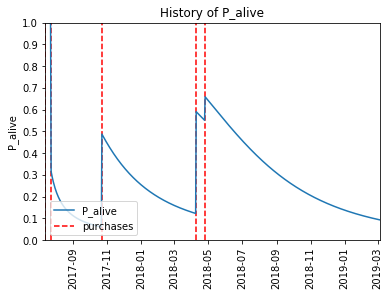

In [495]:

id = '9249130983722228273'
days_since_birth = 600
sp_trans = df.loc[df['fullVisitorId'] == id]
plot_history_alive(bgf, days_since_birth, sp_trans, 'date')
plt.xticks(rotation=90)

(array([736269., 736330., 736389., 736450., 736511., 736573., 736634.,
        736695.]), <a list of 8 Text xticklabel objects>)

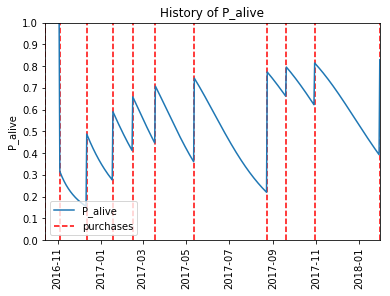

In [496]:

id = '6010250598436085923'
days_since_birth = 300
sp_trans = df.loc[df['fullVisitorId'] == id]
plot_history_alive(bgf, days_since_birth, sp_trans, 'date')
plt.xticks(rotation=90)

(array([736664., 736695., 736726., 736754., 736785., 736815., 736846.,
        736876., 736907., 736938.]), <a list of 10 Text xticklabel objects>)

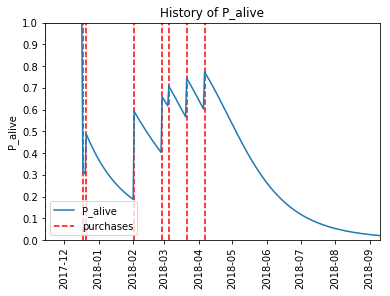

In [497]:


id = '2904329822175970539'
days_since_birth = 300
sp_trans = df.loc[df['fullVisitorId'] == id]
plot_history_alive(bgf, days_since_birth, sp_trans, 'date')
plt.xticks(rotation=90)

(array([736799., 736813., 736815., 736829., 736843., 736846., 736860.,
        736874., 736876., 736890.]), <a list of 10 Text xticklabel objects>)

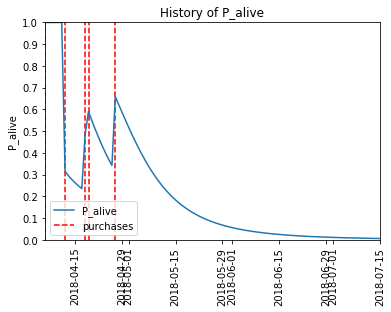

In [498]:
id = '5833663755166786980'
days_since_birth = 100
sp_trans = df.loc[df['fullVisitorId'] == id]
plot_history_alive(bgf, days_since_birth, sp_trans, 'date')
plt.xticks(rotation=90)

### Repeat Customers

In [499]:
returning_customers_summary = summary[summary['frequency']>0]
print(returning_customers_summary.head())

                     frequency  recency      T  monetary_value  \
fullVisitorId                                                    
0010664124684883628        1.0    129.0  209.0    2.922000e+07   
0012276352424581690        1.0     91.0  228.0    5.796300e+08   
0014262055593378383        2.0     18.0  307.0    1.422667e+07   
0036417634769000138        1.0     11.0  578.0    6.023000e+07   
0039541267107154262        1.0      8.0  417.0    4.592000e+07   

                     predicted_purchases  
fullVisitorId                             
0010664124684883628             0.185245  
0012276352424581690             0.123292  
0014262055593378383             0.004733  
0036417634769000138             0.004471  
0039541267107154262             0.006223  


In [500]:
FC=len(df[df['totals.transactionRevenue'] >0].groupby("fullVisitorId")["fullVisitorId"].count())
cnt=len(returning_customers_summary)

In [501]:
len(df.loc[df['totals.transactionRevenue'] >0,'fullVisitorId'].value_counts())

16141

In [502]:
print(FC,cnt)

16141 1466


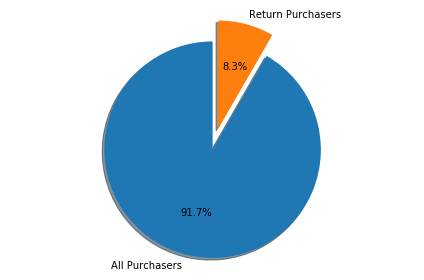

In [503]:
labels = ['All Purchasers', 'Return Purchasers']
sizes = [16141, 1466]

# only "explode" the 2nd slice (i.e. 'Hogs')
explode = (0, 0.2)  

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)

# Equal aspect ratio ensures that pie is drawn as a circle
ax1.axis('equal')  

plt.tight_layout()
plt.show()

In [504]:
returning_customers_summary[['monetary_value', 'frequency']].corr()

,monetary_value,frequency
monetary_value,1.000000,0.267873
frequency,0.267873,1.000000


### Predict CLV for 12 Months with 0.01 Discount

In [505]:
returning_customers_summary['frequency']
from lifetimes import GammaGammaFitter

ggf = GammaGammaFitter(penalizer_coef = 0.01)
ggf.fit(returning_customers_summary['frequency'],returning_customers_summary['monetary_value'])
                                                                     
print(ggf)

<lifetimes.GammaGammaFitter: fitted with 1466 subjects, p: 1.92, q: 0.06, v: 1.72>


In [506]:
#model_ggf.penalizer_coef

In [507]:
#with open('./ggf.pkl', 'wb') as f:
  #  dill.dump(model_ggf, f)

In [508]:
df_clv_3=ggf.customer_lifetime_value(bgf,summary['frequency'],summary['recency'],summary['T'],summary['monetary_value'],18,0.01,'D')
df_clv_6=ggf.customer_lifetime_value(bgf,summary['frequency'],summary['recency'],summary['T'],summary['monetary_value'],6,0.01,'D')
df_clv=ggf.customer_lifetime_value(bgf,summary['frequency'],summary['recency'],summary['T'],summary['monetary_value'],12,0.01,'D')


In [509]:
df_clv=pd.DataFrame(df_clv)
df_clv_3=pd.DataFrame(df_clv_3)
df_clv_6=pd.DataFrame(df_clv_6)

In [510]:
df_clv=df_clv.merge(summary,how='inner',right_index=True,left_index=True)
df_clv_3=df_clv_3.merge(summary,how='inner',right_index=True,left_index=True)
df_clv_6=df_clv_6.merge(summary,how='inner',right_index=True,left_index=True)

In [511]:
df_clv['clv']=df_clv['clv'].astype(float)
df_clv_3['clv']=df_clv_3['clv'].astype(float)
df_clv_6['clv']=df_clv_6['clv'].astype(float)

In [512]:
df_clv = df_clv[df_clv['clv'] >0]
df_clv_3 = df_clv_3[df_clv_3['clv'] >0]
df_clv_6 = df_clv_6[df_clv_6['clv'] >0]

In [518]:
df_clv_act=df_clv[df_clv['predicted_purchases'] >0.5]
df_clv_act_3=df_clv_3[df_clv_3['predicted_purchases'] >0.5]
df_clv_act_6=df_clv_6[df_clv_6['predicted_purchases'] >0.5]
df_clv_act_l=df_clv[df_clv['predicted_purchases'] <0.1]

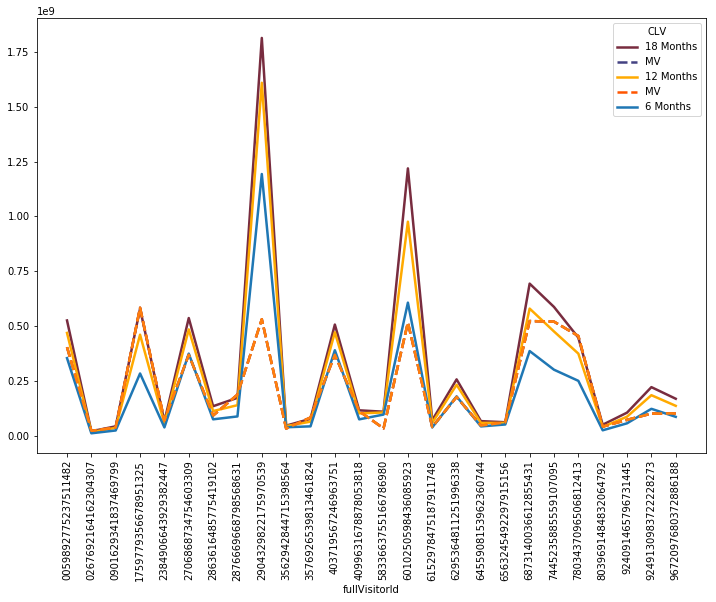

In [515]:
fig = plt.figure(figsize=(12,8))
bx=sns.lineplot(data=df_clv_act_3[['clv','monetary_value']],palette="icefire_r", linewidth=2.5,legend=False)
ax=sns.lineplot(data=df_clv_act[['clv','monetary_value']],palette="autumn_r", linewidth=2.5,legend=False)
cx=sns.lineplot(data=df_clv_act_6[['clv','monetary_value']],palette="tab10", linewidth=2.5,legend=False)
plt.xticks(rotation=90)
plt.legend(title='CLV', loc='upper right', labels=['18 Months','MV','12 Months','MV','6 Months'])
plt.show()

In [467]:
df_clv_act.to_csv('./CapclvGraph.csv',index=True)
df_clv_act_l.to_csv('./CapclvGraph1.csv',index=True)


In [88]:
df.date.max()

Timestamp('2018-04-30 00:00:00')

### RFM Analysis

In [585]:
import datetime as dt
NOW = dt.datetime(2018,5,1)

In [586]:
rfmTable = df.groupby('fullVisitorId').agg({'date': lambda x: (NOW - x.max()).days, # Recency
                                        'totals.transactions': lambda x: len(x),      # Frequency
                                        'totals.transactionRevenue': lambda x: np.log(x.mean())}) # Monetary Value



In [587]:
rfmTable['date'] = rfmTable['date'].astype(int)

In [588]:
rfmTable.rename(columns={'date': 'recency', 
                         'totals.transactions': 'frequency', 
                         'totals.transactionRevenue': 'monetary_value'}, inplace=True)

In [589]:
quantiles=rfmTable.quantile(q=[0.25,0.5,0.75])

In [590]:
quantiles

,recency,frequency,monetary_value
0.25,189.0,1.0,16.906553
0.50,336.0,1.0,17.610100
0.75,500.0,1.0,18.362628


In [591]:
quantiles = quantiles.to_dict()


### Segmentation

In [592]:
rfmSegmentation = rfmTable

In [593]:
# Arguments (x = value, p = recency, monetary_value, frequency, k = quartiles dict)
def RClass(x,p,d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]: 
        return 3
    else:
        return 4
    
# Arguments (x = value, p = recency, monetary_value, frequency, k = quartiles dict)
def FMClass(x,p,d):
    if x <= d[p][0.25]:
        return 4
    elif x <= d[p][0.50]:
        return 3
    elif x <= d[p][0.75]: 
        return 2
    else:
        return 1


In [594]:
rfmSegmentation['R_Quartile'] = rfmSegmentation['recency'].apply(RClass, args=('recency',quantiles))
rfmSegmentation['F_Quartile'] = rfmSegmentation['frequency'].apply(FMClass, args=('frequency',quantiles))
rfmSegmentation['M_Quartile'] = rfmSegmentation['monetary_value'].apply(FMClass, args=('monetary_value',quantiles))

In [595]:
rfmSegmentation['RFMClass'] = rfmSegmentation.R_Quartile.map(str) \
                            + rfmSegmentation.F_Quartile.map(str) \
                            + rfmSegmentation.M_Quartile.map(str)

In [596]:
rfmSegmentation.head(10)

,recency,frequency,monetary_value,R_Quartile,F_Quartile,M_Quartile,RFMClass
fullVisitorId,,,,,,,
0000213131142648941,368,1,17.329739,3,4,3,343
0000384434116640351,209,1,16.065749,2,4,4,244
0001376836098133431,88,1,18.197412,1,4,2,142
0002871498069867123,616,1,18.383498,4,4,1,441
0003450834640354121,560,1,17.875091,4,4,2,442
0003961110741104601,345,1,15.420940,3,4,4,344
000435324061339869,558,1,17.617495,4,4,2,442
0005735902306392332,145,1,17.375420,1,4,3,143
0006911334202687206,287,1,17.884537,2,4,2,242


In [597]:
rfmSegmentation.sort_values('RFMClass', ascending=True,inplace=True)

In [598]:
Best_Customers=rfmSegmentation[rfmSegmentation['RFMClass']=='111']

In [599]:
Loyal_Customers=rfmSegmentation[rfmSegmentation['F_Quartile']==1]

In [600]:
Big_Spenders=rfmSegmentation[rfmSegmentation['M_Quartile']==1]

In [601]:
Almost_Lost=rfmSegmentation[rfmSegmentation['RFMClass']=='311']

In [602]:
Lost_Customers=rfmSegmentation[rfmSegmentation['RFMClass']=='411']

In [603]:
Lost_Cheap_Customers=rfmSegmentation[rfmSegmentation['RFMClass']=='444']

In [604]:
df_cust=pd.DataFrame(columns=['Type','Count'])

In [605]:
df_cust['Type']=['Best_Customers','Loyal_Customers','Big_Spenders','Almost_Lost','Lost_Customers','Lost_Cheap_Customers']

In [606]:
df_cust['count']=[Best_Customers.shape[0],Loyal_Customers.shape[0],Big_Spenders.shape[0],Almost_Lost.shape[0],Lost_Customers.shape[0],Lost_Cheap_Customers.shape[0]]

In [607]:
Loyal_Customers

,recency,frequency,monetary_value,R_Quartile,F_Quartile,M_Quartile,RFMClass
fullVisitorId,,,,,,,
7803437096506812413,93,5,19.935900,1,1,1,111
7862709801346463450,98,2,19.517625,1,1,1,111
9857502878163267725,36,2,19.093166,1,1,1,111
2251154974724567915,139,2,20.004031,1,1,1,111
6236695646664370912,42,2,21.518419,1,1,1,111
2001755752042793942,30,2,19.335671,1,1,1,111
986073514365410344,92,2,18.473842,1,1,1,111
4489775765152255728,180,2,20.371010,1,1,1,111
0933322133919123270,132,2,19.279173,1,1,1,111


In [608]:
Big_Spenders

,recency,frequency,monetary_value,R_Quartile,F_Quartile,M_Quartile,RFMClass
fullVisitorId,,,,,,,
7803437096506812413,93,5,19.935900,1,1,1,111
7862709801346463450,98,2,19.517625,1,1,1,111
9857502878163267725,36,2,19.093166,1,1,1,111
2251154974724567915,139,2,20.004031,1,1,1,111
6236695646664370912,42,2,21.518419,1,1,1,111
2001755752042793942,30,2,19.335671,1,1,1,111
986073514365410344,92,2,18.473842,1,1,1,111
4489775765152255728,180,2,20.371010,1,1,1,111
0933322133919123270,132,2,19.279173,1,1,1,111


In [609]:
Almost_Lost

,recency,frequency,monetary_value,R_Quartile,F_Quartile,M_Quartile,RFMClass
fullVisitorId,,,,,,,
8436426603099391262,455,8,19.823823,3,1,1,311
5632994425337545327,356,2,19.944724,3,1,1,311
3835134197841326255,439,3,21.016055,3,1,1,311
2558254017558848934,341,2,18.389345,3,1,1,311
8883600023735279403,498,2,19.439871,3,1,1,311
2528551022767237058,497,3,18.697858,3,1,1,311
3955127543379144640,365,2,19.632398,3,1,1,311
3753158727494093380,355,2,19.414451,3,1,1,311
7651073139895028250,399,2,18.530118,3,1,1,311


In [610]:
Lost_Customers

,recency,frequency,monetary_value,R_Quartile,F_Quartile,M_Quartile,RFMClass
fullVisitorId,,,,,,,
8986419064533048234,522,2,18.980754,4,1,1,411
294715325435275737,517,2,19.109669,4,1,1,411
8232947695089161227,593,2,20.148195,4,1,1,411
2630626637929580327,542,2,19.619576,4,1,1,411
7737049103084491745,614,2,18.473747,4,1,1,411
3345163376310988493,532,4,19.410120,4,1,1,411
0182664823417063218,620,2,18.512713,4,1,1,411
3244885836845029978,602,3,21.087798,4,1,1,411
7937009225076356808,592,2,20.068079,4,1,1,411


In [611]:
Lost_Cheap_Customers

,recency,frequency,monetary_value,R_Quartile,F_Quartile,M_Quartile,RFMClass
fullVisitorId,,,,,,,
9785268681128245172,518,1,16.759423,4,4,4,444
0297816563358688328,552,1,16.536148,4,4,4,444
9725725636158347694,551,1,16.117095,4,4,4,444
5389664508142113724,526,1,16.424845,4,4,4,444
5500182607993931436,614,1,15.864493,4,4,4,444
6391833308528377505,613,1,15.716124,4,4,4,444
280088274265058989,530,1,16.010510,4,4,4,444
6391006534663669857,516,1,14.686804,4,4,4,444
0375424311834211727,503,1,16.859557,4,4,4,444


[Text(0, 0, 'Best_Customers'),
 Text(0, 0, 'Loyal_Customers'),
 Text(0, 0, 'Big_Spenders'),
 Text(0, 0, 'Almost_Lost'),
 Text(0, 0, 'Lost_Customers'),
 Text(0, 0, 'Lost_Cheap_Customers')]

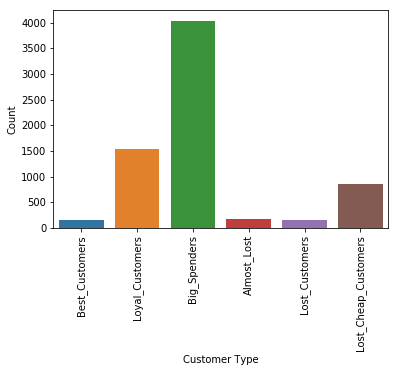

In [612]:
ax=sns.barplot('Type','count',data=df_cust)
loc, labels = plt.xticks()
ax.set(xlabel='Customer Type', ylabel='Count')
ax.set_xticklabels(labels, rotation=90)


### KMeans Clustering

In [613]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

rfmSegmentation_log=rfmSegmentation[['frequency','recency','monetary_value']]
rfmSegmentation_log['recency']=np.log1p(rfmSegmentation['recency'])
rfmSegmentation_log['frequency']=np.log1p(rfmSegmentation['frequency'])

sm=StandardScaler()
rfmSegmentation_log=sm.fit_transform(rfmSegmentation_log)

wcss = []
for i in range(1,11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=0)
    kmeans.fit(rfmSegmentation_log)
    wcss.append(kmeans.inertia_)

In [614]:
wcss

[48423.00000000001,
 35125.04204587148,
 24642.228867447477,
 17229.94536198657,
 14923.044537054837,
 12722.923260630767,
 11249.017329721217,
 10190.078646816193,
 9424.610606336048,
 8553.733619344614]

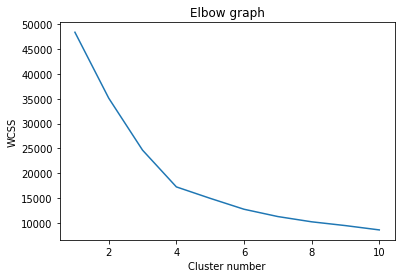

In [615]:
plt.plot(range(1,11), wcss)
plt.title('Elbow graph')
plt.xlabel('Cluster number')
plt.ylabel('WCSS')
plt.show()

Text(0.5, 0, 'Monetary')

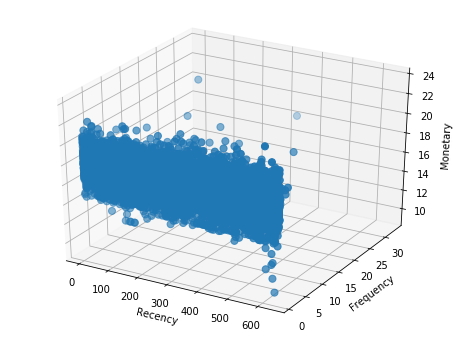

In [616]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(rfmSegmentation.recency, rfmSegmentation.frequency, rfmSegmentation.monetary_value, s=50)

ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary')

In [618]:
kmeans = KMeans(n_clusters=4, init='k-means++', random_state=0)
#rfmSegmentation['monetary_value']=np.log(rfmSegmentation['monetary_value'])
clusters = kmeans.fit_predict(rfmSegmentation_log)

In [619]:
rfmSegmentation.columns

Index(['recency', 'frequency', 'monetary_value', 'R_Quartile', 'F_Quartile',
       'M_Quartile', 'RFMClass'],
      dtype='object')

In [621]:
kmeans_p = KMeans(n_clusters=3, init='k-means++', random_state=0)
kmeans_p=kmeans_p.fit(rfmSegmentation_log)
with open('./kmeans.pkl', 'wb') as f:
    dill.dump(kmeans_p, f)

In [622]:
rfmSegmentation['clusters'] = clusters

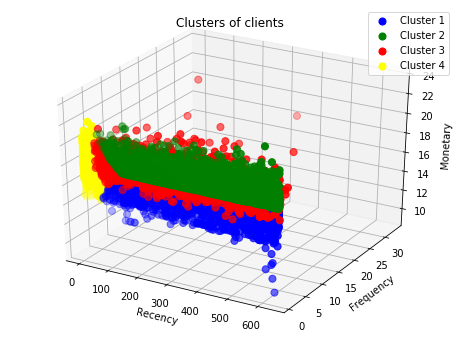

In [623]:

fig = plt.figure(figsize=(8,6))
dx = fig.add_subplot(111, projection='3d')
colors = ['blue','green', 'red','yellow']

for i in range(0,4):
    dx.scatter(rfmSegmentation[rfmSegmentation.clusters == i].recency, 
               rfmSegmentation[rfmSegmentation.clusters == i].frequency, 
               rfmSegmentation[rfmSegmentation.clusters == i].monetary_value, 
               c = colors[i], 
               label = 'Cluster ' + str(i+1), 
               s=50)

dx.set_title('Clusters of clients')
dx.set_xlabel('Recency')
dx.set_ylabel('Frequency')
dx.set_zlabel('Monetary')
dx.legend()

In [624]:
rfmSegmentation[['RFMClass','clusters']]

,RFMClass,clusters
fullVisitorId,,
7803437096506812413,111,2
7862709801346463450,111,2
9857502878163267725,111,2
2251154974724567915,111,2
6236695646664370912,111,2
2001755752042793942,111,2
986073514365410344,111,2
4489775765152255728,111,2
0933322133919123270,111,2


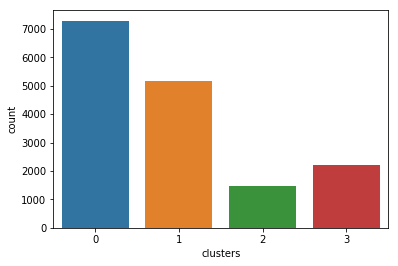

In [625]:
sns.countplot('clusters',data=rfmSegmentation)

In [626]:
rfmSegmentation[rfmSegmentation['clusters']==2]

,recency,frequency,monetary_value,R_Quartile,F_Quartile,M_Quartile,RFMClass,clusters
fullVisitorId,,,,,,,,
7803437096506812413,93,5,19.935900,1,1,1,111,2
7862709801346463450,98,2,19.517625,1,1,1,111,2
9857502878163267725,36,2,19.093166,1,1,1,111,2
2251154974724567915,139,2,20.004031,1,1,1,111,2
6236695646664370912,42,2,21.518419,1,1,1,111,2
2001755752042793942,30,2,19.335671,1,1,1,111,2
986073514365410344,92,2,18.473842,1,1,1,111,2
4489775765152255728,180,2,20.371010,1,1,1,111,2
0933322133919123270,132,2,19.279173,1,1,1,111,2


In [627]:
df_seg=df_clv_act.merge(rfmSegmentation,how='inner',left_index=True,right_index=True)
df_summ=summary.merge(rfmSegmentation,how='inner',left_index=True,right_index=True)
df_summ[['predicted_purchases','RFMClass']]
df_summ.columns
df_un=df.drop_duplicates('fullVisitorId',keep='first').set_index('fullVisitorId')
df_un=df_summ.merge(df_un,how='inner',left_index=True,right_index=True)
df_un.columns


Index(['frequency_x', 'recency_x', 'T', 'monetary_value_x',
       'predicted_purchases', 'recency_y', 'frequency_y', 'monetary_value_y',
       'R_Quartile', 'F_Quartile', 'M_Quartile', 'RFMClass', 'clusters',
       'channelGrouping', 'date', 'visitId', 'visitNumber', 'visitStartTime',
       'device.browser', 'device.deviceCategory', 'device.operatingSystem',
       'geoNetwork.city', 'geoNetwork.continent', 'geoNetwork.country',
       'geoNetwork.metro', 'geoNetwork.networkDomain', 'geoNetwork.region',
       'geoNetwork.subContinent', 'totals.bounces', 'totals.hits',
       'totals.newVisits', 'totals.pageviews', 'totals.sessionQualityDim',
       'totals.timeOnSite', 'totals.totalTransactionRevenue',
       'totals.transactionRevenue', 'totals.transactions',
       'trafficSource.adContent',
       'trafficSource.adwordsClickInfo.adNetworkType',
       'trafficSource.adwordsClickInfo.gclId',
       'trafficSource.adwordsClickInfo.isVideoAd',
       'trafficSource.adwordsClickInf

In [628]:
df_un.to_csv('./CapGraph.csv',index=True)

In [629]:
df_seg.to_csv('./CapSegGraph.csv',index=True)

In [705]:
df_mer=df_clv_act.merge(df_un,how='inner',left_index=True,right_index=True)

In [706]:
df_mer1=df_clv_act_l.merge(df_un,how='inner',left_index=True,right_index=True)

In [707]:
df_grp = df_mer.groupby('geoNetwork.city')['clv'].count().reset_index()

In [708]:
df_grp1 = df_mer1.groupby('geoNetwork.city')['clv'].count().reset_index()

In [709]:
df_grp['per']=df_grp['clv']*100/df_grp['clv'].sum()

In [710]:
df_grp1['per']=df_grp1['clv']*100/df_grp1['clv'].sum()

In [700]:
df_grpm=df_grp1.merge(df_grp,how='outer',on='geoNetwork.city')

In [711]:
df_grpm

,geoNetwork.city,clv_x,per_x,clv_y,per_y
0,Ann Arbor,1.0,3.846154,24,1.955990
1,Austin,4.0,15.384615,38,3.096985
2,Chicago,2.0,7.692308,58,4.726976
3,Mountain View,1.0,3.846154,138,11.246944
4,New York,7.0,26.923077,186,15.158924
5,Salem,1.0,3.846154,6,0.488998
6,San Jose,1.0,3.846154,25,2.037490
7,not available in demo dataset,9.0,34.615385,415,33.822331
8,(not set),NaN,NaN,7,0.570497
9,Atlanta,NaN,NaN,11,0.896496


[Text(0, 0, 'Direct'),
 Text(0, 0, 'Organic Search'),
 Text(0, 0, 'Paid Search'),
 Text(0, 0, 'Referral'),
 Text(0, 0, 'Affiliates'),
 Text(0, 0, 'Display'),
 Text(0, 0, 'Social')]

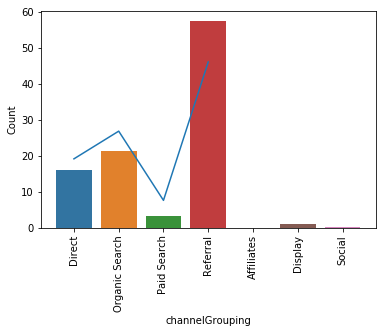

In [687]:
ax = sns.barplot(x="channelGrouping", y="per_y", data=df_grpm)
ax = sns.lineplot(x="channelGrouping", y="per_x", data=df_grpm)
loc, labels = plt.xticks()
ax.set(xlabel='channelGrouping', ylabel='Count')
ax.set_xticklabels(labels, rotation=90)

[Text(0, 0, 'Ann Arbor'),
 Text(0, 0, 'Austin'),
 Text(0, 0, 'Chicago'),
 Text(0, 0, 'Mountain View'),
 Text(0, 0, 'New York'),
 Text(0, 0, 'Salem'),
 Text(0, 0, 'San Jose'),
 Text(0, 0, '(not set)'),
 Text(0, 0, 'Atlanta'),
 Text(0, 0, 'Boston'),
 Text(0, 0, 'Boulder'),
 Text(0, 0, 'Cambridge'),
 Text(0, 0, 'Charlotte'),
 Text(0, 0, 'Chelmsford'),
 Text(0, 0, 'Columbus'),
 Text(0, 0, 'Cupertino'),
 Text(0, 0, 'Denver'),
 Text(0, 0, 'Houston'),
 Text(0, 0, 'Irvine'),
 Text(0, 0, 'Jakarta'),
 Text(0, 0, 'Jersey City'),
 Text(0, 0, 'Kansas City'),
 Text(0, 0, 'Kirkland'),
 Text(0, 0, 'London'),
 Text(0, 0, 'Los Angeles'),
 Text(0, 0, 'Maracaibo'),
 Text(0, 0, 'Melbourne'),
 Text(0, 0, 'Milpitas'),
 Text(0, 0, 'Minneapolis'),
 Text(0, 0, 'Omaha'),
 Text(0, 0, 'Palo Alto'),
 Text(0, 0, 'Philadelphia'),
 Text(0, 0, 'Pittsburgh'),
 Text(0, 0, 'Redmond'),
 Text(0, 0, 'Riverside'),
 Text(0, 0, 'San Antonio'),
 Text(0, 0, 'San Bruno'),
 Text(0, 0, 'San Diego'),
 Text(0, 0, 'San Francisco'),
 Te

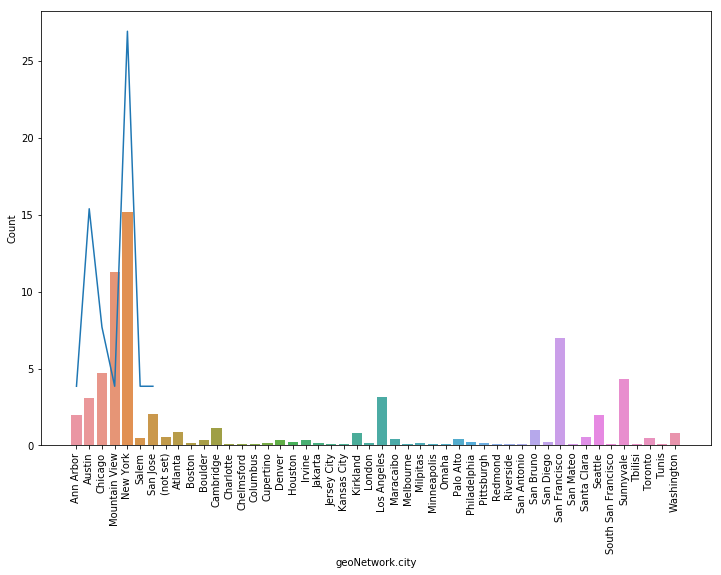

In [715]:
fig = plt.figure(figsize=(12,8))
df_grpm=df_grpm[df_grpm["geoNetwork.city"]!='not available in demo dataset']
ax = sns.barplot(x="geoNetwork.city", y="per_y", data=df_grpm)
ax = sns.lineplot(x="geoNetwork.city", y="per_x", data=df_grpm)
loc, labels = plt.xticks()
ax.set(xlabel='geoNetwork.city', ylabel='Count')
ax.set_xticklabels(labels, rotation=90)

In [ ]:
df_grp['per']=df_grp[]

[Text(0, 0, 'Referral'),
 Text(0, 0, 'Organic Search'),
 Text(0, 0, 'Direct'),
 Text(0, 0, 'Paid Search'),
 Text(0, 0, 'Display'),
 Text(0, 0, 'Social'),
 Text(0, 0, 'Affiliates')]

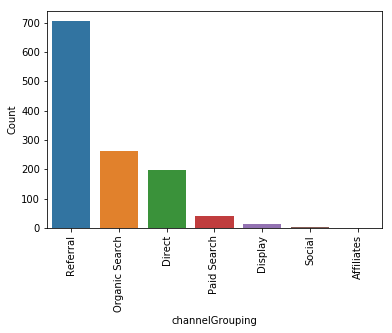

In [646]:
cx=sns.countplot('channelGrouping',data=df_mer1)
loc, labels = plt.xticks()
cx.set(xlabel='channelGrouping', ylabel='Count')
cx.set_xticklabels(labels, rotation=90)